# Installers



In [1]:
!pip install pandas numpy matplotlib statsmodels scipy pmdarima

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 11.0 MB/s eta 0:00:00


# Imports

In [2]:
# Visualization
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.patches import Circle, Patch
from matplotlib.lines import Line2D
from matplotlib.collections import PatchCollection
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.gridspec import GridSpec
from mpl_toolkits.axes_grid1 import make_axes_locatable
import seaborn as sns
import textwrap
from IPython.display import display

# Data handling
import pandas as pd
import pmdarima as pm
from pmdarima.model_selection import train_test_split
from pandas.io.json import json_normalize
import numpy as np
import time
from google.colab import drive
import re
from pathlib import Path

# Models
import statsmodels.api as sm
from scipy import stats
from scipy.stats import pearsonr, spearmanr
import statsmodels.tsa.stattools as smt

In [3]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Functions

This function reads all CSV files in the given directory that contain the category name, processes them, and merges them into a single DataFrame. It ensures that the date index is complete for the specified range.


In [4]:
# Function to process and merge CSV files by category, ensuring the date index is complete and non-zero values are kept
def load_trends(path_to_csvs, category_name, start_date, end_date):
    """
    Args:
    path_to_csvs (str): The path to the directory containing the CSV files.
    category_name (str): Part of the file name that identifies the category of the file.
    start_date (str): The start date for the time series index.
    end_date (str): The end date for the time series index.

    Returns:
    pd.DataFrame: A DataFrame with all the processed and merged data.
    """
    # Define the time range for the index
    date_range = pd.date_range(start=start_date, end=end_date, freq='MS').to_period('M').to_timestamp('M')

    # Initialize an empty DataFrame to hold merged data
    merged_df = pd.DataFrame(index=date_range)

    # Compile a regular expression pattern to clean column names
    column_name_pattern = re.compile(r':\s\(Ecuador\)')

    # Read each CSV file in the directory that contains the category name
    for file in Path(path_to_csvs).glob(f'*{category_name}*.csv'):
        # Read the current CSV into a DataFrame
        df = pd.read_csv(file, skiprows=1)  # Skip the first row which is usually metadata

        # The first column is the date, regardless of its name
        date_col = df.columns[0]

        # Rename columns to remove country specification, like ': (Ecuador)'
        df.columns = [column_name_pattern.sub('', col) if col != date_col else 'Date' for col in df.columns]

        # Convert the date column to datetime and set it as index
        df['Date'] = pd.to_datetime(df['Date']).dt.to_period('M').dt.to_timestamp('M')
        df.set_index('Date', inplace=True)

        # If columns in the new DataFrame match those in the merged DataFrame, add their values
        for col in df.columns:
            if col not in merged_df.columns:
                # If the column is not in merged_df, simply join it
                merged_df = merged_df.join(df[col], how='outer')
            else:
                # If the column exists, sum the values, assuming they are counts of the same trend
                merged_df[col] = merged_df[col].add(df[col], fill_value=0)

    # Fill any remaining NaN values with zeros
    merged_df.fillna(0, inplace=True)

    return merged_df

path = '/content/drive/MyDrive/Diversa/PUCE/Google Trends Data'

This function calculates the weighted sum of the trends in the DataFrame based on the percentage of non-missing values.

In [5]:
def consolidate_trends(df):
    """
    Args:
    df (pd.DataFrame): The DataFrame with trend data to be consolidated.

    Returns:
    pd.DataFrame: A DataFrame with a single column 'Consolidated_Trend' representing the weighted sum of trends.
    """
    # Get the weights based on the % of non-missing values
    weights = (1 - (df == 0).sum() / len(df)).to_dict()
    total_weight = sum(weights.values())
    normalized_weights = {k: v / total_weight for k, v in weights.items()}

    # Apply weights and consolidate
    consolidated_trend = df.multiply(pd.Series(normalized_weights), axis=1).sum(axis=1)
    consolidated_trend = pd.DataFrame(consolidated_trend, columns=['Consolidated_Trend'])

    return consolidated_trend

This function plots the trend data from the DataFrame.

In [6]:
def plot_trend_data(df, category_name):
    """
    Args:
    df (pd.DataFrame): The DataFrame with trend data to be plotted.
    category_name (str): The category name to include in the plot title.
    """
    # Set the style of the seaborn plot
    sns.set(style='whitegrid')

    # Set the size of the figure
    plt.figure(figsize=(10, 4))

    # Define a list of distinct colors for each column
    colors = sns.color_palette('husl', n_colors=len(df.columns))

    # Plot each column in the DataFrame using the colors list
    for (column, color) in zip(df.columns, colors):
        plt.plot(df.index, df[column], label=column, color=color, lw=1.5, linestyle=':')

    # Adding title and labels
    plt.title(f'Google Trends Search Interest Over Time - {category_name} Category', fontsize=11)
    plt.xlabel('Date', fontsize=9)
    plt.ylabel('Monthly Popularity Index', fontsize=9)

    # Add a legend to the plot outside the plot area
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize='small')

    # Show the plot
    plt.show()

This function plots the consolidated trend data from the DataFrame.

In [7]:
def plot_consolidated_trend(consolidated_trend_df, category_name):
    """
    Args:
    consolidated_trend_df (pd.DataFrame): The DataFrame with the consolidated trend data to be plotted.
    category_name (str): The category name to include in the plot title.
    """
    # Set the size of the figure
    plt.figure(figsize=(10, 4))

    # Plot the consolidated time series
    plt.plot(consolidated_trend_df.index, consolidated_trend_df['Consolidated_Trend'], label='Consolidated Trend', color='blue', lw=2)

    # Adding title and labels
    plt.title(f'Consolidated Trends - {category_name} Category', fontsize=11)
    plt.xlabel('Date', fontsize=9)
    plt.ylabel('Weighted Monthly Popularity Index', fontsize=9)

    # Show the plot
    plt.show()

This function fits both an ARIMA and a SARIMA model to the provided time series data and selects the best model based on AIC/BIC. Then extract the residuals of the best fitted model.
    

In [8]:
def fit_model_and_extract_residuals(df, seasonal_period=12):
    """
    Args:
    df (pd.DataFrame): A DataFrame with the time series data in the first column.
    seasonal_period (int): The number of time steps for a single seasonal period.

    Returns:
    pd.DataFrame: A DataFrame containing the residuals of the best-fit model for the entire dataset.
    """
    # Extract the time series (assuming it's the first column)
    time_series = df.iloc[:, 0]

    # Fit ARIMA model (non-seasonal)
    arima_model = pm.auto_arima(time_series, seasonal=False, trace=True,
                                error_action='ignore', suppress_warnings=True,
                                stepwise=True)

    # Fit SARIMA model (seasonal)
    sarima_model = pm.auto_arima(time_series, seasonal=True, m=seasonal_period,
                                 trace=True, error_action='ignore', suppress_warnings=True,
                                 stepwise=True)

    # Choose the model with the lower AIC/BIC
    best_model = sarima_model if sarima_model.aic() < arima_model.aic() else arima_model
    model_type = "SARIMA" if best_model is sarima_model else "ARIMA"

    # Extract residuals and create a DataFrame with model parameters in the column name
    column_name = f'{model_type} ({best_model.order})'
    if model_type == "SARIMA":
        column_name += f'({best_model.seasonal_order})'
    residuals = pd.DataFrame(best_model.resid(), index=df.index, columns=[column_name])

    return residuals

This function plots the residuals of a fitted time series model.

In [9]:
def plot_residuals(residuals_df, category_name):
    """
    Args:
    residuals_df (pd.DataFrame): The DataFrame containing the residuals to be plotted. The column name should include the model name and its parameters.
    category_name (str): The category name to include in the plot title.
    """
    # Extract model name and parameters from the column name
    model_info = residuals_df.columns[0]

    # Set the size of the figure
    plt.figure(figsize=(10, 6))

    # Plot the residuals
    plt.plot(residuals_df, color='purple', lw=1.5)

    # Adding title and labels
    plt.title(f'{model_info} - {category_name} Category', fontsize=11)
    plt.xlabel('Date', fontsize=9)
    plt.ylabel('Residuals', fontsize=9)

    # Show the plot
    plt.show()

# Google Trends Data

## General Category




In [10]:
trends_cat_general = load_trends(path, 'General', '2011-01-01', '2021-12-31')
trends_cat_general.head()

suicidio  suicidio en Ecuador  intento de suicidio  suicidarse  \
2011-01-31        43                    4                    6           7   
2011-02-28        63                    0                    0           0   
2011-03-31        53                    3                    4           4   
2011-04-30        49                   10                    0           0   
2011-05-31        58                    0                    0           6   

            suicidarme  
2011-01-31           5  
2011-02-28           0  
2011-03-31           0  
2011-04-30           0  
2011-05-31           0

In [11]:
trends_cat_general.tail()

suicidio  suicidio en Ecuador  intento de suicidio  suicidarse  \
2021-08-31        30                    0                    1          10   
2021-09-30        61                    4                    2          11   
2021-10-31        35                    1                    0          12   
2021-11-30        29                    2                    0           7   
2021-12-31        48                    3                    1           8   

            suicidarme  
2021-08-31           1  
2021-09-30           5  
2021-10-31           3  
2021-11-30           3  
2021-12-31           0

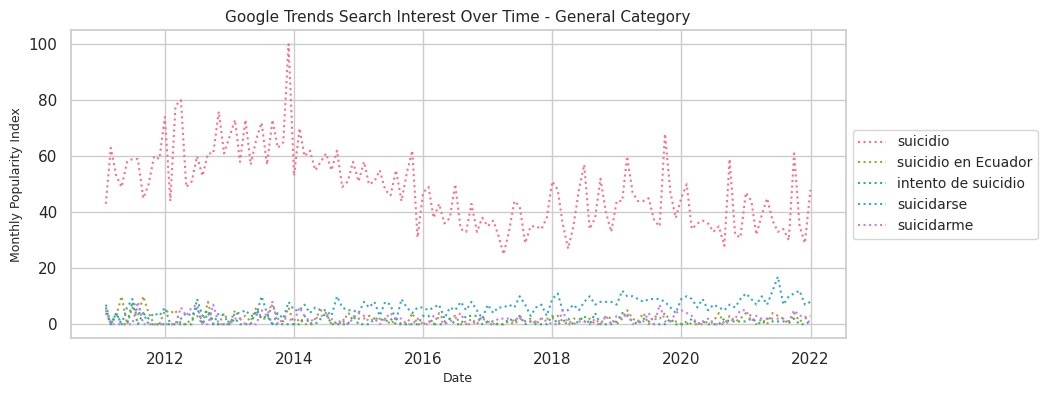

In [12]:
# Use the function to plot data for the 'General' category
plot_trend_data(trends_cat_general, 'General')

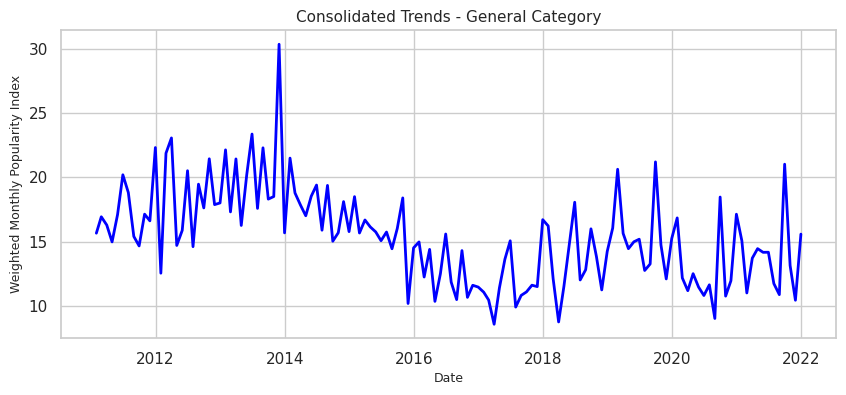

In [13]:
trend_cat_general = consolidate_trends(trends_cat_general)
plot_consolidated_trend(trend_cat_general, 'General')

In [14]:
residuals_general = fit_model_and_extract_residuals(trends_cat_general)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=966.189, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1048.356, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1015.855, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=970.941, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1046.357, Time=0.04 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=973.919, Time=0.24 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=965.511, Time=0.21 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=970.606, Time=0.13 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=979.413, Time=0.14 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=967.247, Time=0.26 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=975.232, Time=0.24 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.43 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=963.898, Time=0.13 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=969.136, Time=0.07 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=977.48

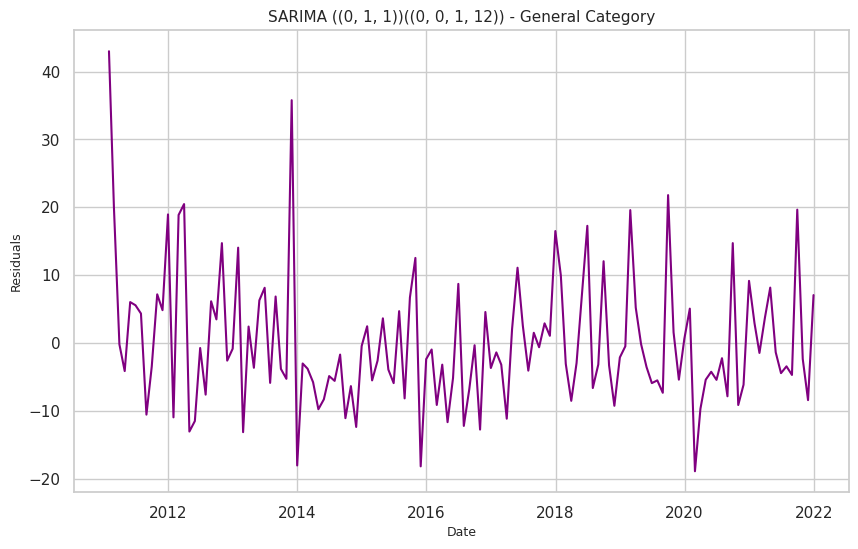

In [15]:
plot_residuals(residuals_general, 'General')

## Seeking Category




In [16]:
trends_cat_seeking = load_trends(path, 'Seeking', '2011-01-01', '2021-12-31')
trends_cat_seeking.head()

intento de suicidio  como suicidarme  como suicidarse  \
2011-01-31                   68                0                0   
2011-02-28                    0                0                0   
2011-03-31                   44                0               60   
2011-04-30                    0                0                0   
2011-05-31                    0                0                0   

            como matarme  como matarse  matarme  matarse  sobredosis  \
2011-01-31             0            74       19       23          18   
2011-02-28             0            39       32        0          36   
2011-03-31             0            54       13        0          31   
2011-04-30             0             0       11       10          38   
2011-05-31            56             0       22        0          31   

            suicidio asistido  suicidarse sin dolor  formas de suicidio  \
2011-01-31                 11                     0                  21   
2011-02-28                  0                     8                   0   
2011-03-31                 13                     0                   0   
2011-04-30                  0                     7                  37   
2011-05-31                  0                    12                   0   

            formas de suicidarse  como suicidarme sin dolor  \
2011-01-31                     0                          0   
2011-02-28                     0                         24   
2011-03-31                     0                          0   
2011-04-30                     0                          0   
2011-05-31                     0                          0   

            como suicidarse sin dolor  nota de suicidio  
2011-01-31                         12                12  
2011-02-28                         16                 0  
2011-03-31                          0                17  
2011-04-30                          0                 0  
2011-05-31                          0                39

In [17]:
trends_cat_seeking.tail()

intento de suicidio  como suicidarme  como suicidarse  \
2021-08-31                   12                0               50   
2021-09-30                   26               23               55   
2021-10-31                    0               18               55   
2021-11-30                    0               22               29   
2021-12-31                   15               24               36   

            como matarme  como matarse  matarme  matarse  sobredosis  \
2021-08-31            11            18       11        6          32   
2021-09-30            15            33        7        5          27   
2021-10-31            13            21        6        0          26   
2021-11-30            20             0        9        7          30   
2021-12-31            15            14       16        3          25   

            suicidio asistido  suicidarse sin dolor  formas de suicidio  \
2021-08-31                  2                     3                   0   
2021-09-30                  0                     0                  11   
2021-10-31                  0                     2                   0   
2021-11-30                  4                     3                   0   
2021-12-31                  5                     0                   0   

            formas de suicidarse  como suicidarme sin dolor  \
2021-08-31                     3                          4   
2021-09-30                     0                          0   
2021-10-31                     3                          5   
2021-11-30                     0                          5   
2021-12-31                     5                          0   

            como suicidarse sin dolor  nota de suicidio  
2021-08-31                          5                 0  
2021-09-30                          0                 5  
2021-10-31                          0                 0  
2021-11-30                          8                 0  
2021-12-31                          0                 0

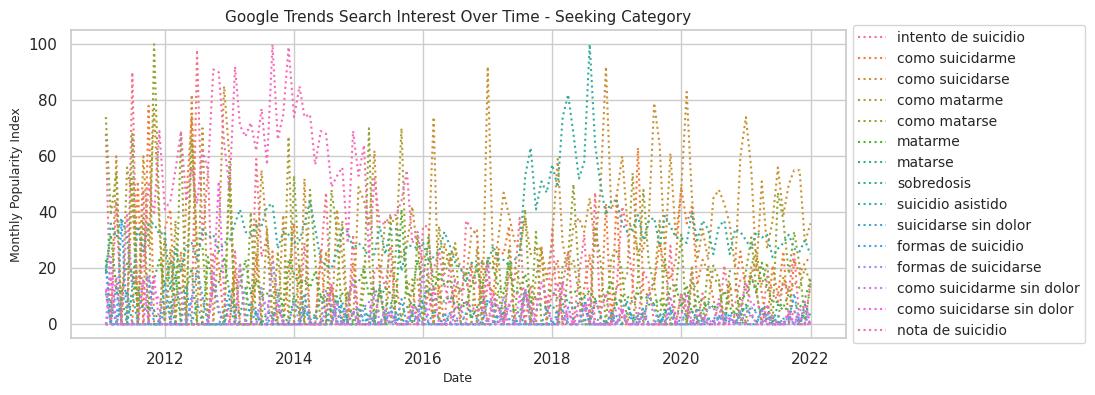

In [18]:
# Use the function to plot data for the 'General' category
plot_trend_data(trends_cat_seeking, 'Seeking')

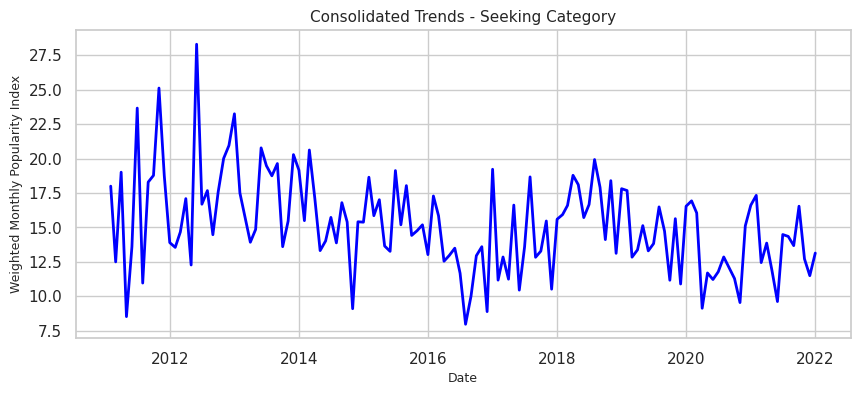

In [19]:
trend_cat_seeking = consolidate_trends(trends_cat_seeking)
plot_consolidated_trend(trend_cat_seeking, 'Seeking')

In [20]:
residuals_seeking = fit_model_and_extract_residuals(trend_cat_seeking)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.29 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=754.898, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=718.215, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=683.304, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=752.908, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=685.298, Time=0.07 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=685.299, Time=0.06 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=687.304, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=681.779, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=683.777, Time=0.04 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=683.777, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=716.231, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=685.768, Time=0.08 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 0.808 seconds
Performing stepwise search to minimize 

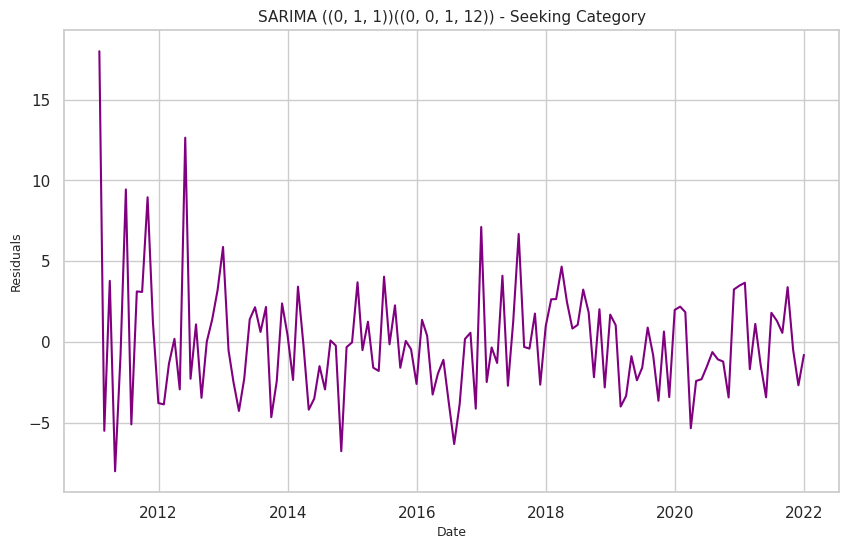

In [21]:
plot_residuals(residuals_seeking, 'Seeking')

## Prevention Category




In [22]:
trends_cat_prevention = load_trends(path, 'Prevention', '2011-01-01', '2021-12-31')
trends_cat_prevention.head()

ayuda psicologica  ayuda psicológica  psicologo  psicólogo  \
2011-01-31                 14                  0         64         10   
2011-02-28                 10                  0         48          0   
2011-03-31                  0                  0         49          0   
2011-04-30                  7                  0         61         13   
2011-05-31                  4                  0         55          6   

            sicologo  psicoterapia  terapia psicologica + terapia psicológica  \
2011-01-31        20            68                                         15   
2011-02-28         0           100                                         23   
2011-03-31        12            42                                         16   
2011-04-30         5            21                                          0   
2011-05-31         0            93                                         11   

            atención psicológica + atencion psicologica  psiquiatra  \
2011-01-31                                           12          26   
2011-02-28                                           21          45   
2011-03-31                                            0           0   
2011-04-30                                            0         100   
2011-05-31                                            0           0   

            siquiatra  prevencion del suicidio  
2011-01-31          0                       22  
2011-02-28         42                        0  
2011-03-31         26                       20  
2011-04-30          0                        0  
2011-05-31          0                        0

In [23]:
trends_cat_prevention.tail()

ayuda psicologica  ayuda psicológica  psicologo  psicólogo  \
2021-08-31                  3                  3         81         47   
2021-09-30                  3                  2         65         39   
2021-10-31                  3                  7         70         41   
2021-11-30                  3                  6         66         37   
2021-12-31                  4                  4         72         45   

            sicologo  psicoterapia  terapia psicologica + terapia psicológica  \
2021-08-31         5            46                                         15   
2021-09-30         9            24                                         14   
2021-10-31         6            45                                         12   
2021-11-30         6            50                                         18   
2021-12-31         4            34                                         13   

            atención psicológica + atencion psicologica  psiquiatra  \
2021-08-31                                            5          88   
2021-09-30                                            7          91   
2021-10-31                                            6          67   
2021-11-30                                            0          65   
2021-12-31                                            4          73   

            siquiatra  prevencion del suicidio  
2021-08-31         10                        3  
2021-09-30          0                       39  
2021-10-31          0                        0  
2021-11-30          3                        9  
2021-12-31          0                        6

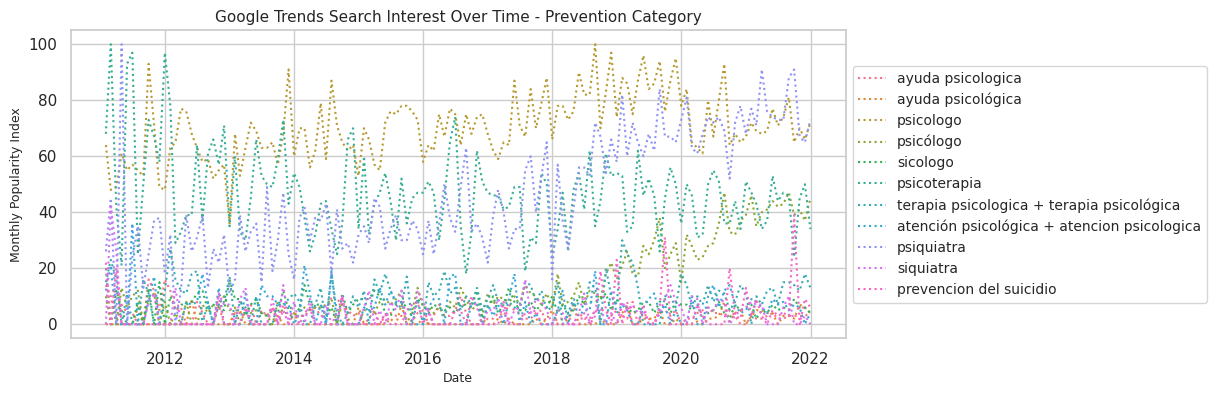

In [24]:
# Use the function to plot data for the 'General' category
plot_trend_data(trends_cat_prevention, 'Prevention')

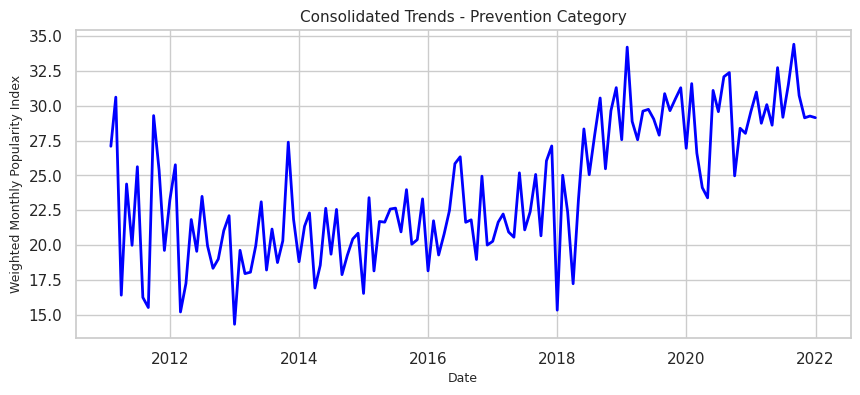

In [25]:
trend_cat_prevention = consolidate_trends(trends_cat_prevention)
plot_consolidated_trend(trend_cat_prevention, 'Prevention')

In [26]:
residuals_prevention = fit_model_and_extract_residuals(trend_cat_prevention)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=685.457, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=754.865, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=721.230, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=684.438, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=752.867, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=686.080, Time=0.06 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=685.961, Time=0.06 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=686.867, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=683.495, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=684.996, Time=0.03 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=684.820, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=719.231, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=686.057, Time=0.06 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 0.586 seconds
Performing stepwise search to minim

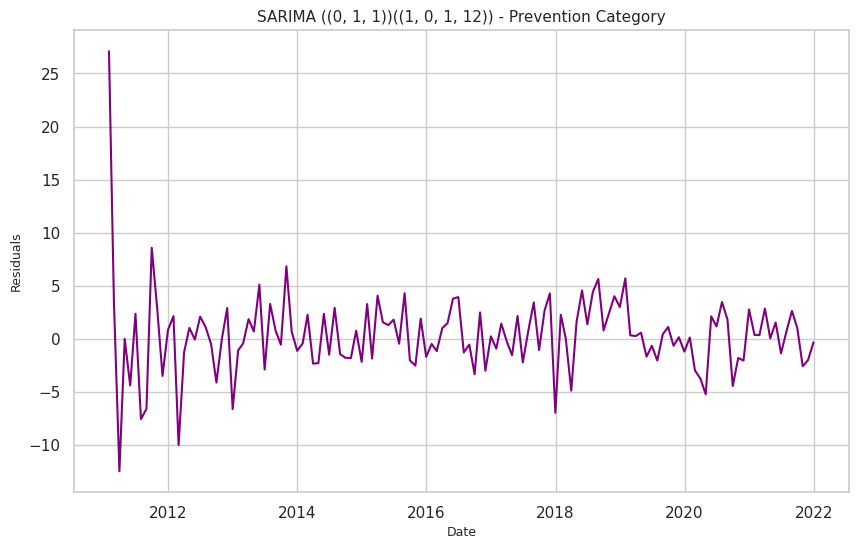

In [27]:
plot_residuals(residuals_prevention, 'Prevention')

## Mood Category




In [28]:
trends_cat_mood = load_trends(path, 'Mood', '2011-01-01', '2021-12-31')
trends_cat_mood.head()

no quiero vivir  ya no quiero vivir  pánico + panico  \
2011-01-31               29                   0               19   
2011-02-28               30                   0               40   
2011-03-31               12                  13               43   
2011-04-30               19                   0               47   
2011-05-31               15                   0               44   

            ataques de panico  ataque de pánico  tengo miedo  fobia  \
2011-01-31                 12                 0           74     36   
2011-02-28                 30                 0           71     46   
2011-03-31                 14                11           70     46   
2011-04-30                 14                 0           57     44   
2011-05-31                 15                11           44     31   

            sentimientos de tristeza  estoy triste  estoy enojado  ...  \
2011-01-31                         0            22              0  ...   
2011-02-28                         0            17             14  ...   
2011-03-31                         0            11              0  ...   
2011-04-30                         0            19              0  ...   
2011-05-31                         0            16              0  ...   

            no tengo a nadie  mejorar el autoestima  mejorar la autoestima  \
2011-01-31                 0                     87                      0   
2011-02-28                 0                     43                      0   
2011-03-31                 0                     79                     58   
2011-04-30                 0                      0                      0   
2011-05-31                 0                    100                     90   

            amarse a uno mismo  estoy cansado  estoy cansada  cansancio  \
2011-01-31                   0              0              0         33   
2011-02-28                  61             10              0         34   
2011-03-31                   0             23              0         51   
2011-04-30                   0             21              0         11   
2011-05-31                   0              9              0         32   

            fatiga  cómo ser feliz + como ser feliz  paz interior  
2011-01-31      22                                0            19  
2011-02-28      57                              100             0  
2011-03-31      24                               54             0  
2011-04-30      42                               50            18  
2011-05-31      32                               44             0  

[5 rows x 28 columns]

In [29]:
trends_cat_mood.tail()

no quiero vivir  ya no quiero vivir  pánico + panico  \
2021-08-31               13                   0               60   
2021-09-30                7                   3               46   
2021-10-31                5                   2               49   
2021-11-30                8                   5               48   
2021-12-31               13                   3               48   

            ataques de panico  ataque de pánico  tengo miedo  fobia  \
2021-08-31                  8                 2           44     60   
2021-09-30                  7                 0           33     50   
2021-10-31                  2                 0           40     44   
2021-11-30                  5                 0           30     43   
2021-12-31                  6                 2           40     58   

            sentimientos de tristeza  estoy triste  estoy enojado  ...  \
2021-08-31                         0            18              2  ...   
2021-09-30                         0            26              5  ...   
2021-10-31                         2            19              7  ...   
2021-11-30                         6            24              3  ...   
2021-12-31                         3            22              3  ...   

            no tengo a nadie  mejorar el autoestima  mejorar la autoestima  \
2021-08-31                20                     38                     26   
2021-09-30                13                     26                     17   
2021-10-31                20                     23                     18   
2021-11-30                14                     18                      0   
2021-12-31                28                     17                     12   

            amarse a uno mismo  estoy cansado  estoy cansada  cansancio  \
2021-08-31                   9              2              6         73   
2021-09-30                   0             10              9         69   
2021-10-31                  10             16             13         80   
2021-11-30                  12              9              9         71   
2021-12-31                   8              9              9         92   

            fatiga  cómo ser feliz + como ser feliz  paz interior  
2021-08-31      79                               24            12  
2021-09-30      69                               25             0  
2021-10-31      67                               31            17  
2021-11-30      71                               39            17  
2021-12-31      83                               21            13  

[5 rows x 28 columns]

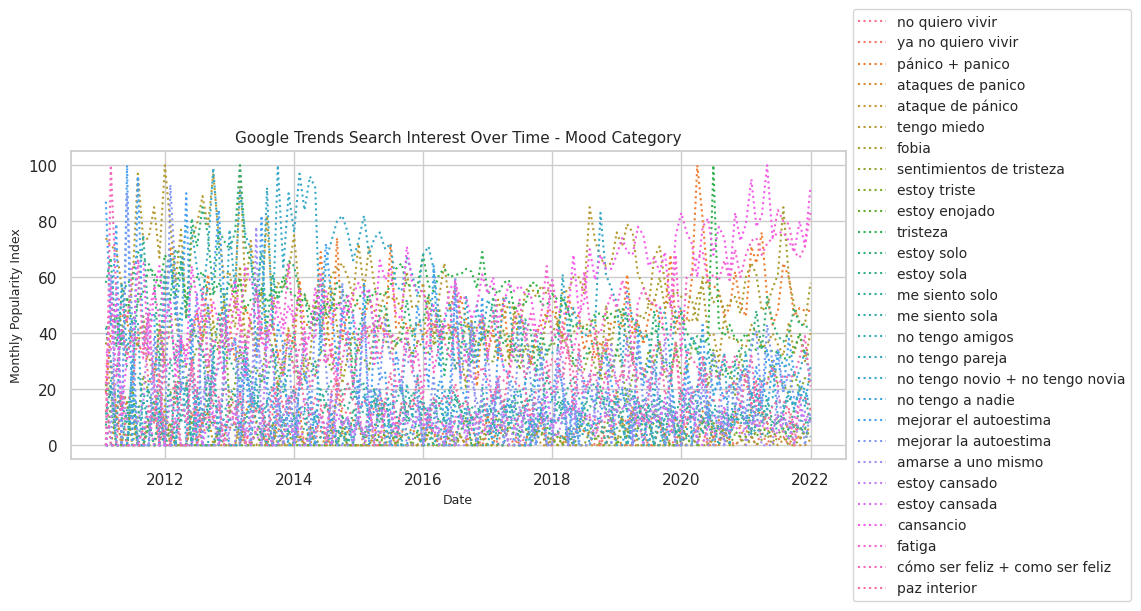

In [30]:
# Use the function to plot data for the 'General' category
plot_trend_data(trends_cat_mood, 'Mood')

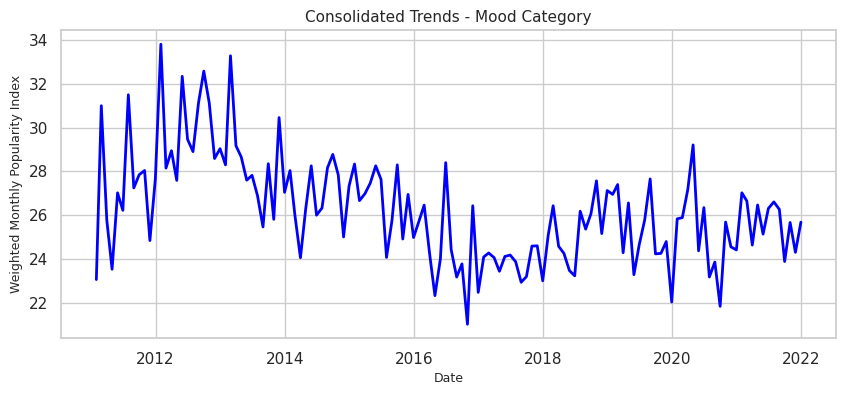

In [31]:
trend_cat_mood = consolidate_trends(trends_cat_mood)
plot_consolidated_trend(trend_cat_mood, 'Mood')

In [32]:
residuals_mood = fit_model_and_extract_residuals(trend_cat_mood)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=552.256, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=608.881, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=576.259, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=546.676, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=606.889, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=548.539, Time=0.04 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=548.525, Time=0.05 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=549.155, Time=0.21 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=544.769, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=546.624, Time=0.03 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=546.609, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=574.260, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=547.160, Time=0.14 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 0.822 seconds
Performing stepwise search to minim

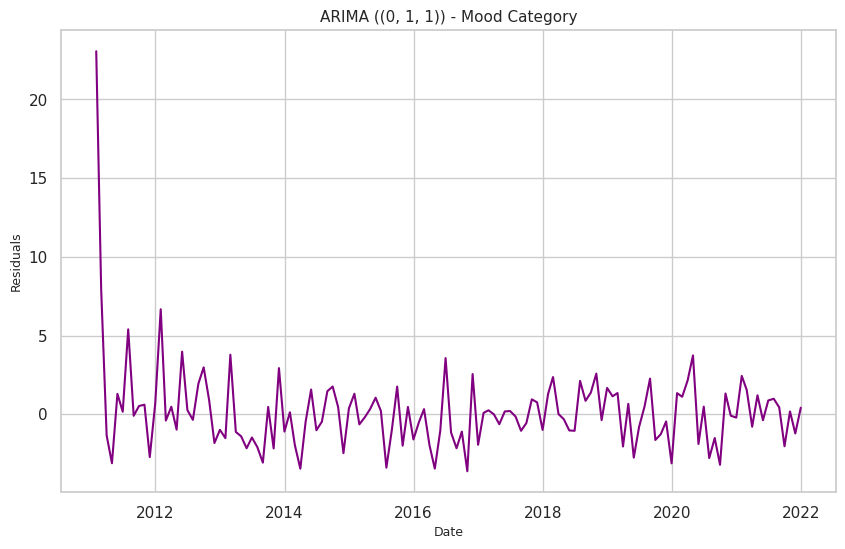

In [33]:
plot_residuals(residuals_mood, 'Mood')

## Disorders Category




In [34]:
trends_cat_disorder = load_trends(path, 'Disorders', '2011-01-01', '2021-12-31')
trends_cat_disorder = trends_cat_disorder.replace('<1',1)
for col in trends_cat_disorder.columns:
  trends_cat_disorder[col] = pd.to_numeric(trends_cat_disorder[col], errors='coerce')
trends_cat_disorder.head()

depresión  depresion  tengo depresión + tengo depresion  \
2011-01-31         12         89                                  0   
2011-02-28         15         70                                  5   
2011-03-31         12         64                                  0   
2011-04-30          8         64                                  0   
2011-05-31         11         69                                  0   

            sintomas de depresion  síntomas de depresión  depresion ecuador  \
2011-01-31                      9                      0                 64   
2011-02-28                      0                      3                  0   
2011-03-31                      0                      0                 47   
2011-04-30                      5                      0                 44   
2011-05-31                      4                      2                 53   

            depresión ecuador  antidepresivo  ansiedad  síntomas de ansiedad  \
2011-01-31                  0             89        22                     0   
2011-02-28                  0             84        19                     0   
2011-03-31                  0              0        23                     0   
2011-04-30                  0              0        21                     0   
2011-05-31                 49              0        29                     0   

            ...  TEPT  anorexia  \
2011-01-31  ...     0        94   
2011-02-28  ...     0        90   
2011-03-31  ...     0        61   
2011-04-30  ...     0        54   
2011-05-31  ...     5       100   

            síntomas de la anorexia + sintomas de la anorexia  \
2011-01-31                                                  0   
2011-02-28                                                 10   
2011-03-31                                                  5   
2011-04-30                                                  0   
2011-05-31                                                  0   

            tratamiento anorexia  insomnio  no puedo dormir  no tengo sueño  \
2011-01-31                     0        24                0              12   
2011-02-28                     0        25               13               0   
2011-03-31                     0        11               35              24   
2011-04-30                     0        17                0               0   
2011-05-31                     0         9               26               0   

            trastorno del sueño  pastillas para dormir  tengo pesadillas  
2011-01-31                    0                     45                 0  
2011-02-28                   15                      0                 0  
2011-03-31                    0                     23                 0  
2011-04-30                    0                     14                19  
2011-05-31                    0                     42                 0  

[5 rows x 33 columns]

In [35]:
trends_cat_disorder.tail()

depresión  depresion  tengo depresión + tengo depresion  \
2021-08-31         49         75                                  3   
2021-09-30         45         78                                  1   
2021-10-31         45         74                                  3   
2021-11-30         50         83                                  1   
2021-12-31         56         82                                  2   

            sintomas de depresion  síntomas de depresión  depresion ecuador  \
2021-08-31                      3                      2                 25   
2021-09-30                      3                      2                 30   
2021-10-31                      4                      0                 17   
2021-11-30                      3                      3                 44   
2021-12-31                      5                      4                 25   

            depresión ecuador  antidepresivo  ansiedad  síntomas de ansiedad  \
2021-08-31                 22             13        71                     3   
2021-09-30                 16              0        67                     2   
2021-10-31                 38             34        66                     1   
2021-11-30                 27             24        76                     1   
2021-12-31                 37             19        79                     2   

            ...  TEPT  anorexia  \
2021-08-31  ...     4        46   
2021-09-30  ...     5        31   
2021-10-31  ...    23        26   
2021-11-30  ...     9        39   
2021-12-31  ...     3        37   

            síntomas de la anorexia + sintomas de la anorexia  \
2021-08-31                                                  3   
2021-09-30                                                  1   
2021-10-31                                                  1   
2021-11-30                                                  1   
2021-12-31                                                  2   

            tratamiento anorexia  insomnio  no puedo dormir  no tengo sueño  \
2021-08-31                     4        32               41              15   
2021-09-30                     1        23               46               0   
2021-10-31                     0        24               46              18   
2021-11-30                     1        27               46              13   
2021-12-31                     0        24               55              23   

            trastorno del sueño  pastillas para dormir  tengo pesadillas  
2021-08-31                    0                     72                 0  
2021-09-30                    7                     56                 8  
2021-10-31                    8                     73                 7  
2021-11-30                    0                     64                12  
2021-12-31                    4                     65                 6  

[5 rows x 33 columns]

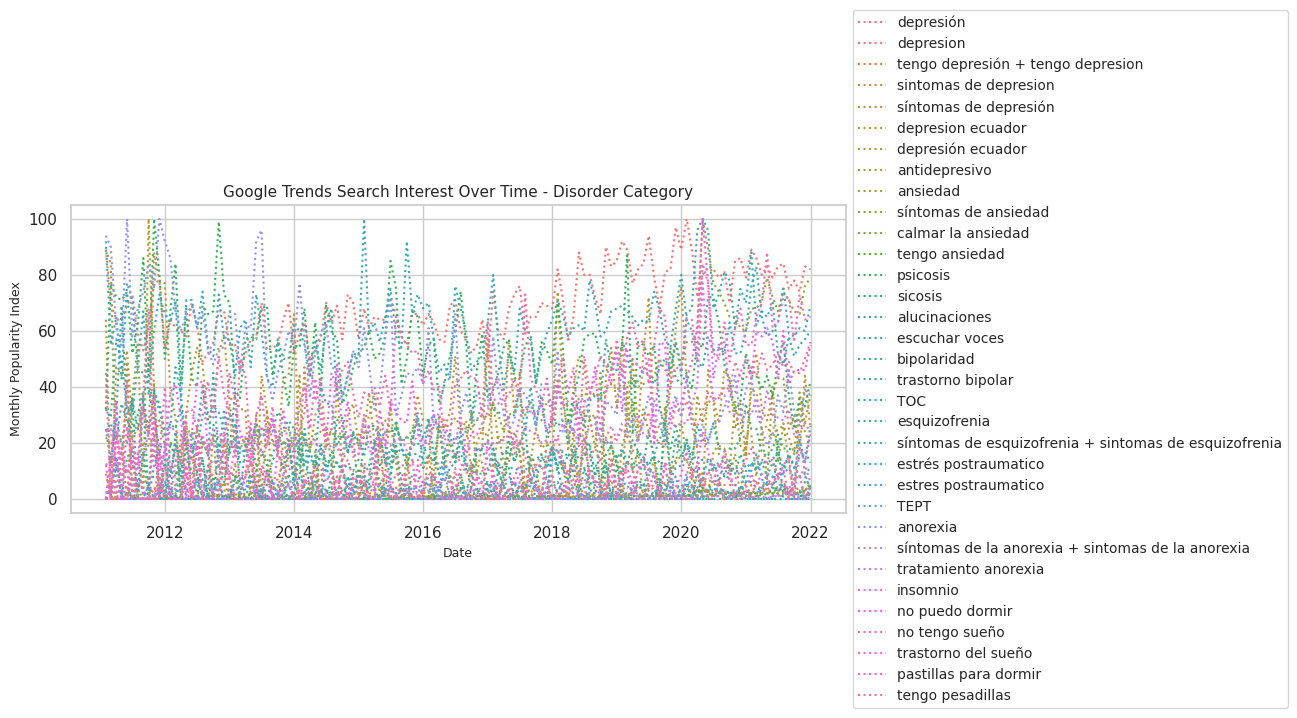

In [36]:
# Use the function to plot data for the 'General' category
plot_trend_data(trends_cat_disorder, 'Disorder')

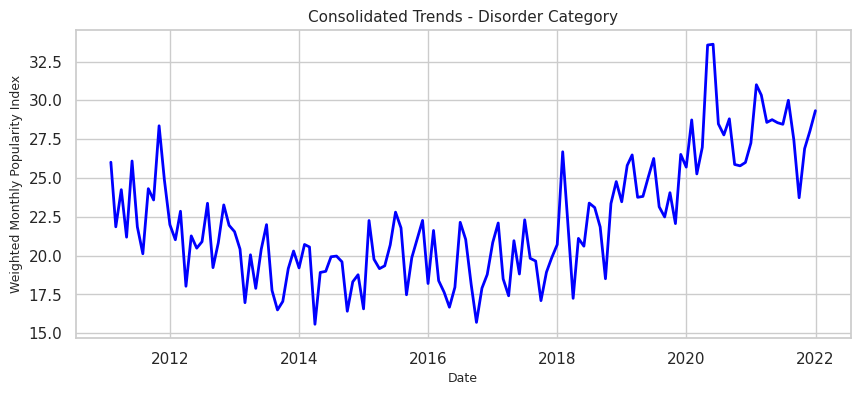

In [37]:
trend_cat_disorder = consolidate_trends(trends_cat_disorder)
plot_consolidated_trend(trend_cat_disorder, 'Disorder')

In [38]:
residuals_disorders = fit_model_and_extract_residuals(trend_cat_disorder)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=593.158, Time=0.27 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=629.464, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=619.181, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=599.612, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=627.477, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=596.986, Time=0.10 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=596.517, Time=0.07 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=598.945, Time=0.20 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=590.149, Time=0.38 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=594.439, Time=0.20 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.38 sec
 ARIMA(2,1,4)(0,0,0)[0] intercept   : AIC=inf, Time=0.44 sec
 ARIMA(1,1,4)(0,0,0)[0] intercept   : AIC=595.519, Time=0.26 sec
 ARIMA(3,1,4)(0,0,0)[0] intercept   : AIC=inf, Time=0.44 sec
 ARIMA(2,1,3)(0,0,0)[0]             : AIC=inf, Time=0.31 se

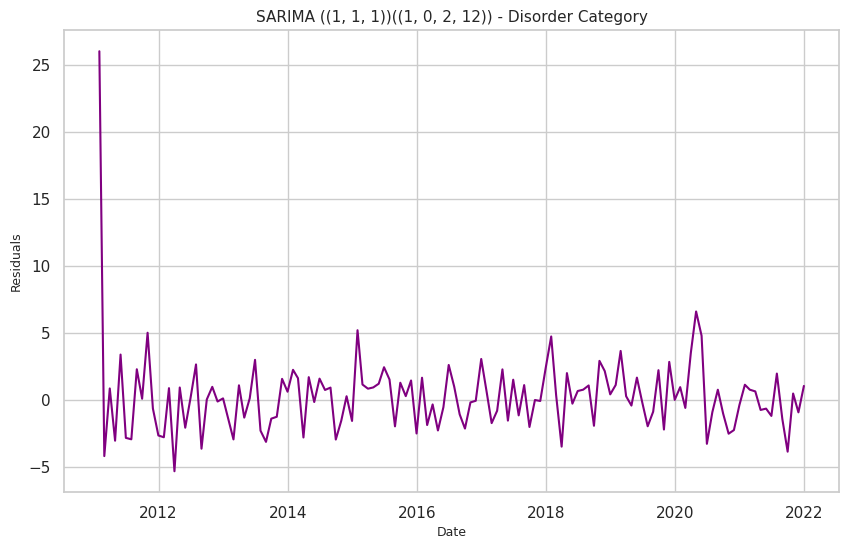

In [39]:
plot_residuals(residuals_disorders, 'Disorder')

## Stress Category




In [40]:
trends_cat_stress = load_trends(path, 'Stress', '2011-01-01', '2021-12-31')
trends_cat_stress = trends_cat_stress.replace('<1',1)
for col in trends_cat_stress.columns:
  trends_cat_stress[col] = pd.to_numeric(trends_cat_stress[col], errors='coerce')
trends_cat_stress.head()

ruptura  ruptura amorosa  divorcio  separación  separacion  \
2011-01-31       45                6        85           6          67   
2011-02-28       22                0        62           7          45   
2011-03-31       18                2        61           6          35   
2011-04-30       16                0        52           3          42   
2011-05-31       16                0        71           6          54   

            presión en el trabajo  burnout  estrés laboral  me divorcie  \
2011-01-31                      0       76              26            0   
2011-02-28                      0       83               0            0   
2011-03-31                      0       47               0            0   
2011-04-30                      0       82               0            0   
2011-05-31                      0       69               0            0   

            traicion  infidelidad  no tengo dinero  problemas económicos  \
2011-01-31        45           72                0                     0   
2011-02-28        64           30                3                     0   
2011-03-31        43           55                5                     0   
2011-04-30        58           46                0                     0   
2011-05-31        44           50                2                     0   

            deudas  problemas economicos  me despidieron  no tengo trabajo  \
2011-01-31      13                     7               0                 0   
2011-02-28      13                     0               0                55   
2011-03-31      18                     6              65                 0   
2011-04-30      17                     2               0                95   
2011-05-31      16                     5               0                 0   

            donde buscar trabajo  
2011-01-31                     0  
2011-02-28                     0  
2011-03-31                     0  
2011-04-30                     0  
2011-05-31                     0

In [41]:
trends_cat_stress.tail()

ruptura  ruptura amorosa  divorcio  separación  separacion  \
2021-08-31       22                4        60          19          23   
2021-09-30       21                2        59          28          29   
2021-10-31       20                3        52          22          22   
2021-11-30       21                4        54          27          26   
2021-12-31       22                3        53          23          26   

            presión en el trabajo  burnout  estrés laboral  me divorcie  \
2021-08-31                     24       70               8            0   
2021-09-30                     15       65              16            0   
2021-10-31                     10       39               0            0   
2021-11-30                      4       70              22            1   
2021-12-31                      9       62              13            0   

            traicion  infidelidad  no tengo dinero  problemas económicos  \
2021-08-31        18           35                5                     2   
2021-09-30        20           27                4                     6   
2021-10-31        20           31                3                     5   
2021-11-30        22           35                5                     4   
2021-12-31        20           31                5                     4   

            deudas  problemas economicos  me despidieron  no tengo trabajo  \
2021-08-31      92                     3               0                37   
2021-09-30      83                     1              13                45   
2021-10-31      68                     3              17                46   
2021-11-30      73                     3               0                32   
2021-12-31      73                     4               0                55   

            donde buscar trabajo  
2021-08-31                     8  
2021-09-30                    12  
2021-10-31                     0  
2021-11-30                     0  
2021-12-31                     0

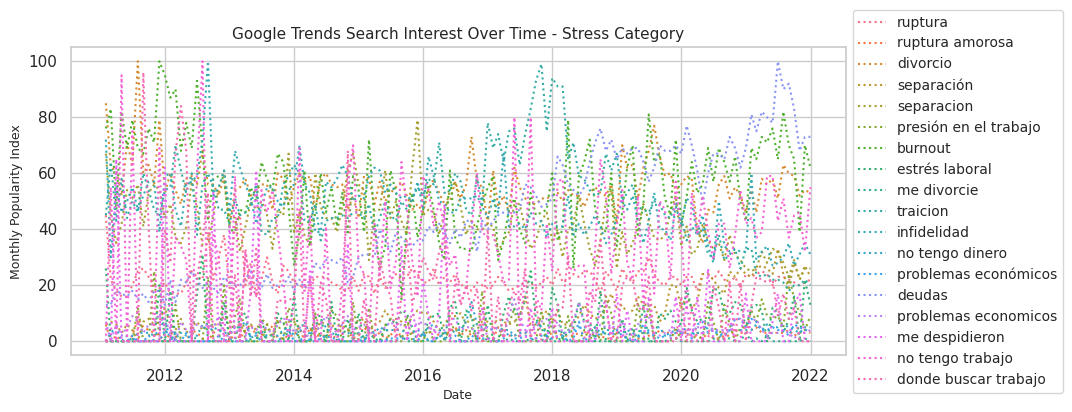

In [42]:
# Use the function to plot data for the 'General' category
plot_trend_data(trends_cat_stress, 'Stress')

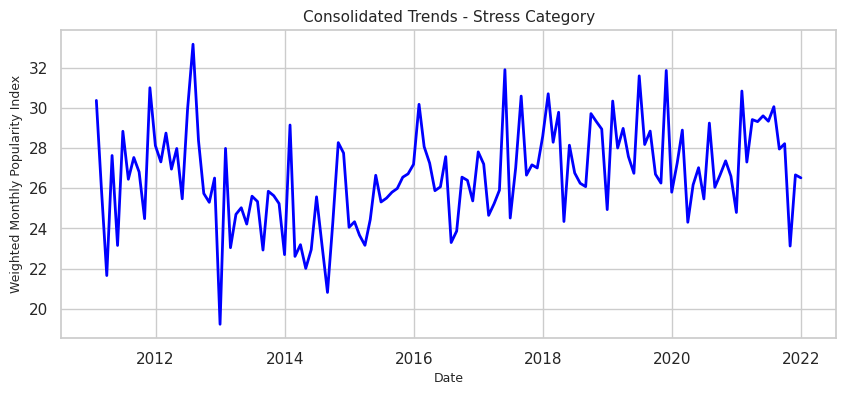

In [43]:
trend_cat_stress = consolidate_trends(trends_cat_stress)
plot_consolidated_trend(trend_cat_stress, 'Stress')

In [44]:
residuals_stress = fit_model_and_extract_residuals(trend_cat_stress)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.25 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=663.981, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=623.227, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=594.026, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=661.994, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=595.898, Time=0.06 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=595.916, Time=0.05 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.26 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=592.049, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=593.917, Time=0.03 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=593.934, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=621.242, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=inf, Time=0.22 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 1.063 seconds
Performing stepwise search to minimize aic
 ARI

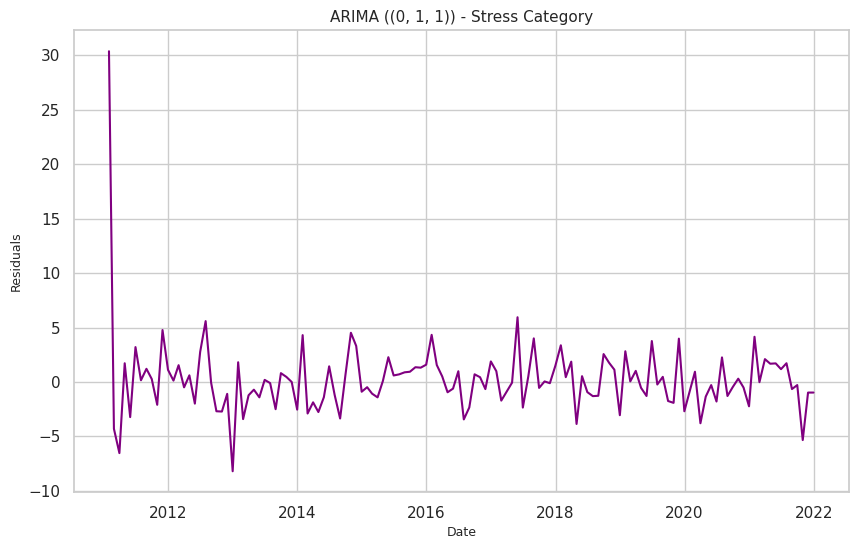

In [45]:
plot_residuals(residuals_stress, 'Stress')

## Trauma Category




In [46]:
trends_cat_trauma = load_trends(path, 'Trauma', '2011-01-01', '2021-12-31')
trends_cat_trauma = trends_cat_trauma.replace('<1',1)
for col in trends_cat_trauma.columns:
  trends_cat_trauma[col] = pd.to_numeric(trends_cat_trauma[col], errors='coerce')
trends_cat_trauma.head()

abuso sexual  violacion sexual  violencia familiar  \
2011-01-31            28                13                   8   
2011-02-28            25                 6                  10   
2011-03-31            15                 3                  13   
2011-04-30            27                 0                   3   
2011-05-31            28                 4                  17   

            violencia doméstica + violencia domestica  maltrato familiar  \
2011-01-31                                          0                  9   
2011-02-28                                          0                  4   
2011-03-31                                          0                  4   
2011-04-30                                          4                  4   
2011-05-31                                          4                  3   

            extorsión + extorsion  amenazas  bullying  
2011-01-31                      0         8         5  
2011-02-28                      2         7         5  
2011-03-31                      1         6         5  
2011-04-30                      0         8         5  
2011-05-31                      0         8         6

In [47]:
trends_cat_trauma.tail()

abuso sexual  violacion sexual  violencia familiar  \
2021-08-31            31                 2                   5   
2021-09-30            20                 3                   5   
2021-10-31            42                 5                   7   
2021-11-30            95                 5                  19   
2021-12-31            73                 6                  13   

            violencia doméstica + violencia domestica  maltrato familiar  \
2021-08-31                                          3                  1   
2021-09-30                                          2                  1   
2021-10-31                                          2                  3   
2021-11-30                                          8                  3   
2021-12-31                                          5                  1   

            extorsión + extorsion  amenazas  bullying  
2021-08-31                      2        13        18  
2021-09-30                      2        14        22  
2021-10-31                      2        13        24  
2021-11-30                      3        15        22  
2021-12-31                      2        15        22

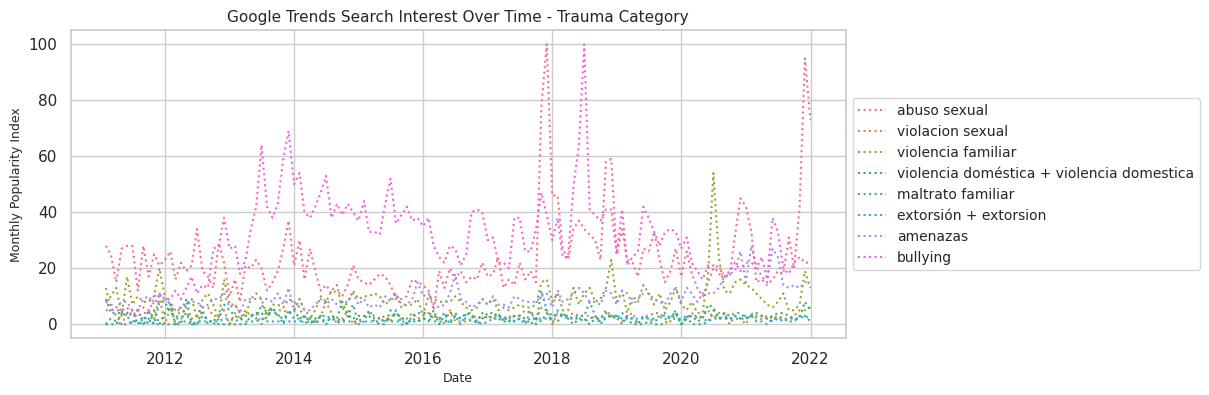

In [48]:
# Use the function to plot data for the 'General' category
plot_trend_data(trends_cat_trauma, 'Trauma')

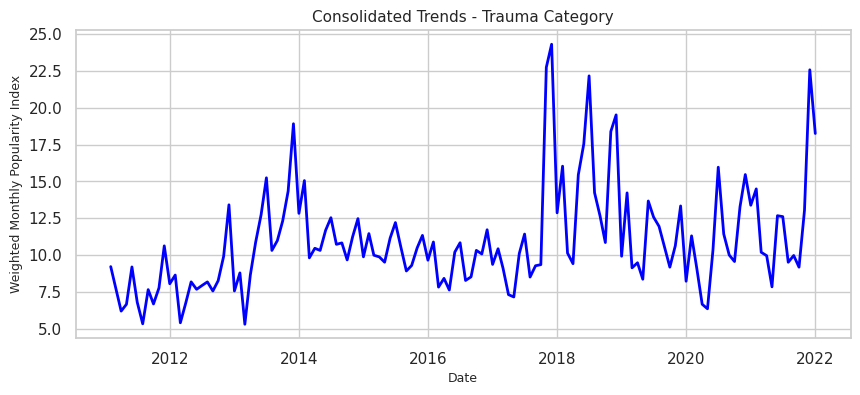

In [49]:
trend_cat_trauma = consolidate_trends(trends_cat_trauma)
plot_consolidated_trend(trend_cat_trauma, 'Trauma')

In [50]:
residuals_trauma= fit_model_and_extract_residuals(trend_cat_trauma)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.27 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=687.315, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=682.648, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=673.535, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=685.373, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.18 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=661.157, Time=0.05 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.22 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.20 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.51 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=659.918, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=672.007, Time=0.04 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=660.662, Time=0.14 sec
 ARIMA(0,1,3)(0,0,0)[0]             : AIC=658.744, Time=0.13 sec
 ARIMA(1,1,3)(0,0,0)[0]             : AIC=660.744, Time=0.15 sec
 A

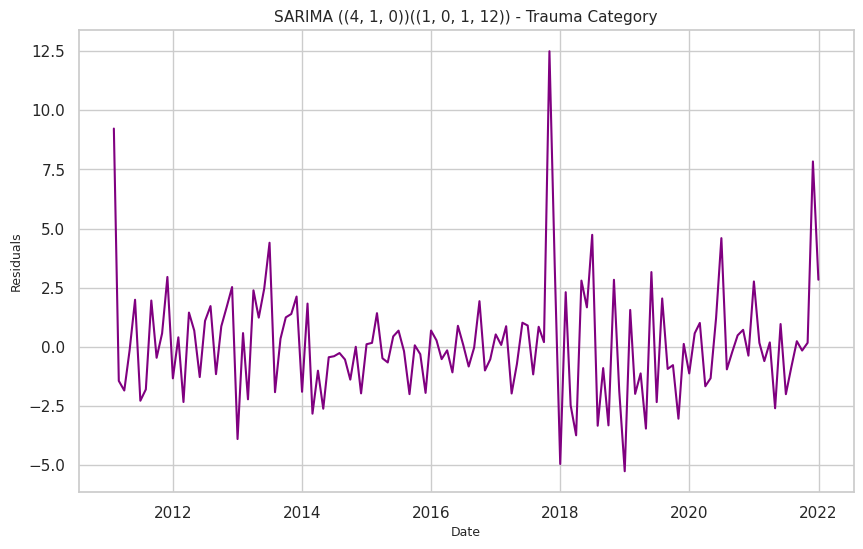

In [51]:
plot_residuals(residuals_trauma, 'Trauma')

## Minorities Category




In [52]:
trends_cat_minorities = load_trends(path, 'Minorities', '2011-01-01', '2021-12-31')
trends_cat_minorities = trends_cat_minorities.replace('<1',1)
for col in trends_cat_minorities.columns:
  trends_cat_minorities[col] = pd.to_numeric(trends_cat_minorities[col], errors='coerce')
trends_cat_minorities.head()

homofobia  lesbofobia  transfobia  racismo  discriminación racial  \
2011-01-31         32           0          13       10                      0   
2011-02-28          0           0           0       10                      0   
2011-03-31          0           0           0       23                      2   
2011-04-30         43           0           0       15                      6   
2011-05-31         36           0           0       34                      4   

            xenofobia  como migrar  trabajo eeuu + trabajo estados unidos  \
2011-01-31          2            0                                     53   
2011-02-28          4            2                                     33   
2011-03-31          6            4                                      0   
2011-04-30          5            0                                     25   
2011-05-31          5            2                                     22   

            trabajo mexico + trabajo México  
2011-01-31                                0  
2011-02-28                                0  
2011-03-31                               10  
2011-04-30                               24  
2011-05-31                               31

In [53]:
trends_cat_minorities.tail()

homofobia  lesbofobia  transfobia  racismo  discriminación racial  \
2021-08-31         28           0           3       15                      2   
2021-09-30         24           0           3       17                      2   
2021-10-31         24           0           3       18                      1   
2021-11-30         22           0           9       22                      1   
2021-12-31         15           0           0       15                      1   

            xenofobia  como migrar  trabajo eeuu + trabajo estados unidos  \
2021-08-31          6            1                                     56   
2021-09-30          8            1                                     48   
2021-10-31          7            1                                     51   
2021-11-30          9            0                                    100   
2021-12-31          8            1                                     57   

            trabajo mexico + trabajo México  
2021-08-31                                7  
2021-09-30                               18  
2021-10-31                               10  
2021-11-30                                8  
2021-12-31                                6

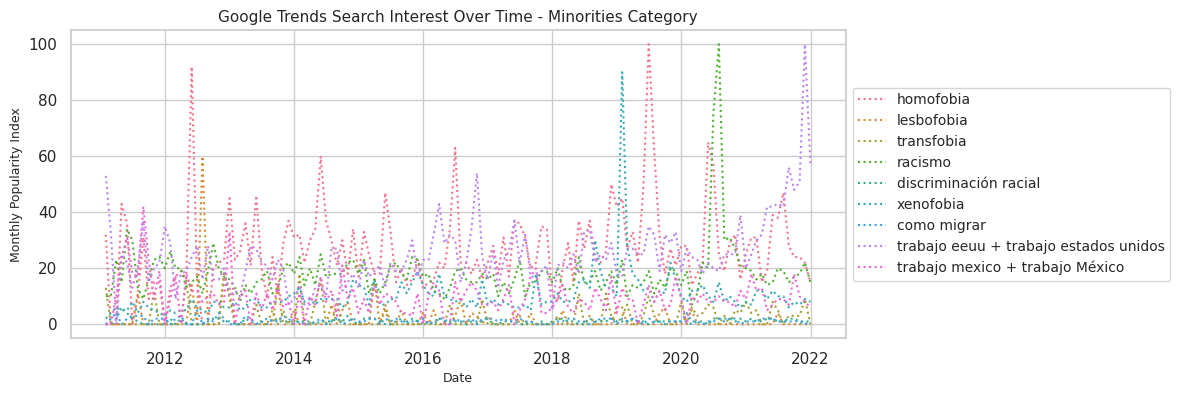

In [54]:
# Use the function to plot data for the 'General' category
plot_trend_data(trends_cat_minorities, 'Minorities')

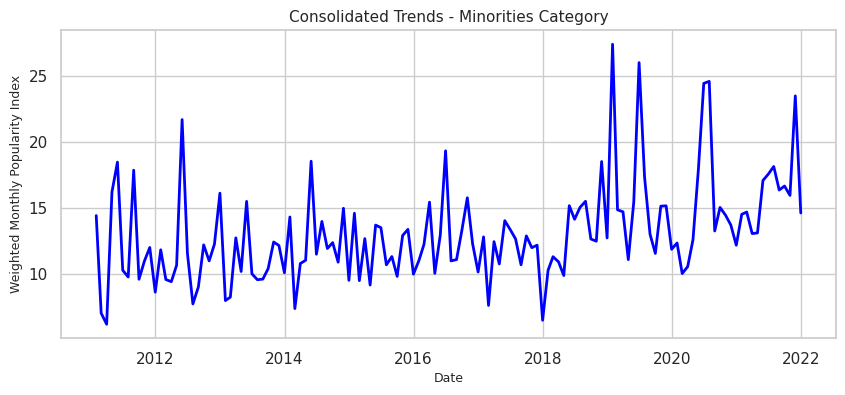

In [55]:
trend_cat_minorities = consolidate_trends(trends_cat_minorities)
plot_consolidated_trend(trend_cat_minorities, 'Minorities')

In [56]:
residuals_minorities= fit_model_and_extract_residuals(trend_cat_minorities)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.66 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=769.344, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=747.823, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=704.166, Time=0.19 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=767.344, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.33 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.22 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=705.472, Time=0.03 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0] intercept
Total fit time: 1.709 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=inf, Time=0.70 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=769.344, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=730.449, Time=0.08 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=inf, Time=0.37 sec
 ARIMA(0,1,0

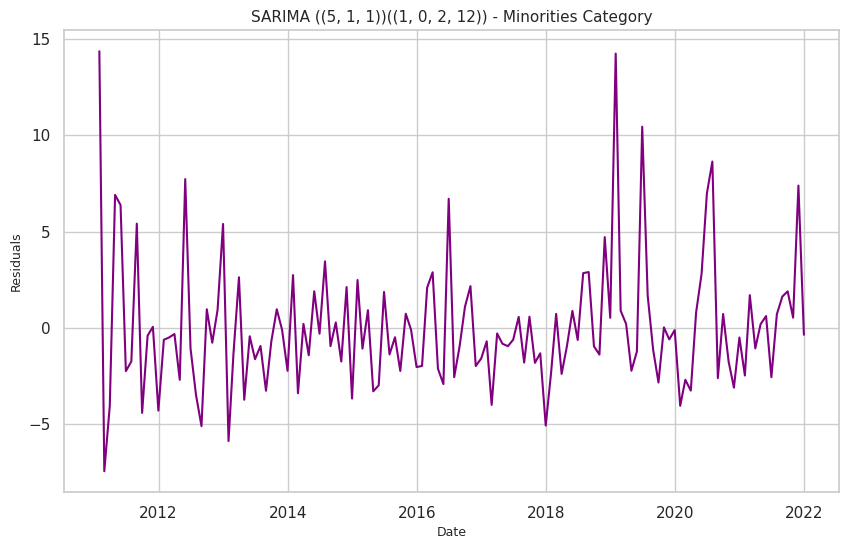

In [57]:
plot_residuals(residuals_minorities, 'Minorities')

## Digital Violence Category




In [58]:
trends_cat_digital = load_trends(path, 'Digital', '2011-01-01', '2021-12-31')
trends_cat_digital = trends_cat_digital.replace('<1',1)
for col in trends_cat_digital.columns:
  trends_cat_digital[col] = pd.to_numeric(trends_cat_digital[col], errors='coerce')
trends_cat_digital.head()

ciberacoso  cyberbullying  bullying cibernético  \
2011-01-31           0              0                    15   
2011-02-28           0              0                     0   
2011-03-31           0              0                    27   
2011-04-30           0              0                     0   
2011-05-31           0              0                     0   

            acoso en internet  acoso en redes sociales  
2011-01-31                  0                        0  
2011-02-28                  0                        0  
2011-03-31                  0                        0  
2011-04-30                  0                        0  
2011-05-31                  0                        0

In [59]:
trends_cat_digital.tail()

ciberacoso  cyberbullying  bullying cibernético  \
2021-08-31          24              5                     0   
2021-09-30          32              9                     2   
2021-10-31           7              7                     0   
2021-11-30          18              8                     0   
2021-12-31          11              7                     0   

            acoso en internet  acoso en redes sociales  
2021-08-31                  0                        0  
2021-09-30                  3                        0  
2021-10-31                  0                        0  
2021-11-30                  4                        1  
2021-12-31                  0                        2

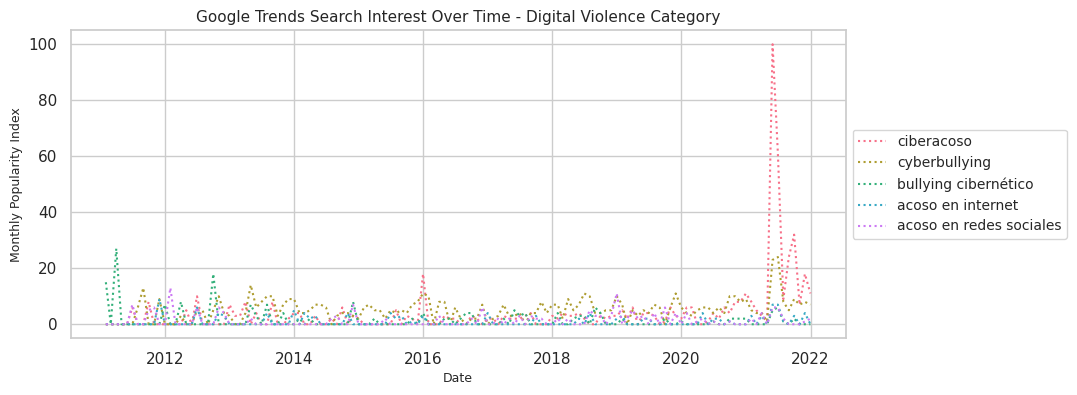

In [60]:
# Use the function to plot data for the 'General' category
plot_trend_data(trends_cat_digital, 'Digital Violence')

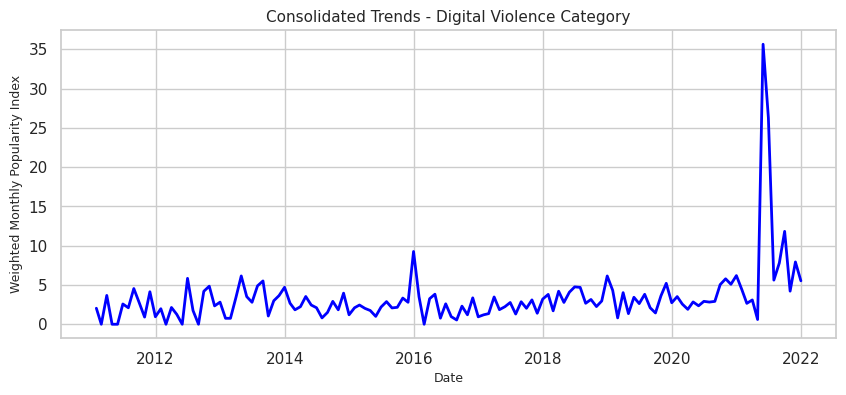

In [61]:
trend_cat_digital = consolidate_trends(trends_cat_digital)
plot_consolidated_trend(trend_cat_digital, 'Digital Violence')

In [62]:
residuals_digital= fit_model_and_extract_residuals(trend_cat_digital)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=706.888, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=753.891, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=748.826, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=718.349, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=751.896, Time=0.01 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=705.371, Time=0.08 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=704.659, Time=0.10 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=705.120, Time=0.10 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=710.698, Time=0.07 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=707.998, Time=0.21 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=704.497, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=717.568, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=705.062, Time=0.05 sec
 ARIMA(0,1,3)(0,0,0)[0]             : AIC=704.722, Time=0.05 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=710.5

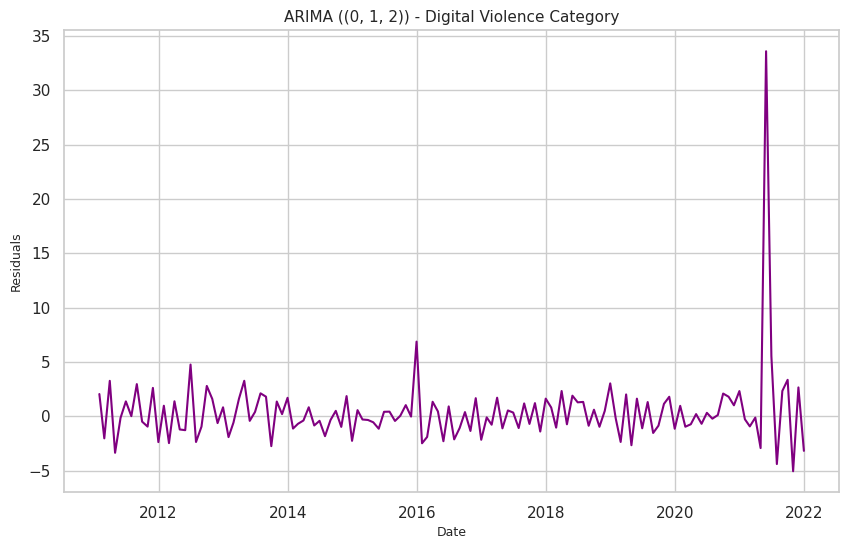

In [63]:
plot_residuals(residuals_digital, 'Digital Violence')

# Residuals Dataframe

In [64]:
# Dictionary of DataFrames with their respective category names
res_names = {
    'digital': residuals_digital,
    'stress': residuals_stress,
    'trauma': residuals_trauma,
    'general': residuals_general,
    'mood': residuals_mood,
    'minorities': residuals_minorities,
    'disorders': residuals_disorders,
    'prevention': residuals_prevention,
    'seeking': residuals_seeking
}

# Rename the columns and concatenate the DataFrames
combined_residuals_df = pd.concat(
    [df.rename(columns={df.columns[0]: category.capitalize()}) for category, df in res_names.items()],
    axis=1
)
combined_residuals_df.index.name = 'Date'

In [65]:
# Export the DataFrame to a CSV file delimited by pipes '|'
combined_residuals_df.to_csv('/content/drive/MyDrive/Diversa/PUCE/Google Trends Data/GoogleTrends_residuals.csv', sep='|', index=True)

# Final Plots

## Plotting Functions

In [66]:
def plot_combined_trends(ax, df_trends, df_consolidated, category_name, space):
    """
    Plot search terms with a gradient color based on their importance and overlay the
    consolidated trend on the same y-axis.
    """
    # Plot the individual search terms using a reversed gray color palette
    term_importance = df_trends.sum().sort_values(ascending=False)
    num_colors = len(df_trends.columns)
    colors = sns.color_palette("Greys", n_colors=num_colors)[::-1]

    # Ensure index is in datetime format for proper plotting
    df_trends.index = pd.to_datetime(df_trends.index)
    df_consolidated.index = pd.to_datetime(df_consolidated.index)

    # Plot each search term
    for i, column in enumerate(term_importance.index):
        ax.plot(df_trends.index, df_trends[column], color=colors[i], lw=0.7, alpha=0.3)

    # Plot the consolidated trend with a contrasting color
    consolidated_color = sns.color_palette("flare", 1)
    ax.plot(df_consolidated.index, df_consolidated['Consolidated_Trend'], color=consolidated_color[0], lw=1.3)

    # Set the title and axis labels
    ax.text(0.02, 1.02, f'{category_name} category search trends |', transform=ax.transAxes, fontsize=8, color='#303030', ha='left', va='center')
    ax.text(space, 1.02, 'weighted trend', transform=ax.transAxes, fontsize=8, color=consolidated_color[0], ha='left', va='center')
    ax.set_ylabel('popularity index', fontsize=6)
    # Customize ticks and grid
    ax.tick_params(axis='y', labelsize=6)
    ax.tick_params(axis='x', labelbottom=False)

    #ax.set_xticks([])
    ax.yaxis.grid(True, linestyle='--', linewidth=0.7, alpha=0.7)
    ax.xaxis.grid(True, linestyle='--', linewidth=0.7, alpha=0.7)

    # Set spines visibility
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)


In [94]:
def plot_residuals(ax, df_residuals):
    """
    Plot residuals
    """
    # Plot the individual search terms using a reversed gray color palette
    df_residuals.index = pd.to_datetime(df_residuals.index)
    model_info = df_residuals.columns[0]
    color = sns.color_palette("flare", 10)
    ax.plot(df_residuals[model_info], color='black', lw=1)
    ax.text(0.02, 1.02, f'Prewhitened Trend: {model_info}', transform=ax.transAxes, fontsize=8, color='#303030', ha='left', va='center')
    ax.set_xlabel('date', fontsize=6)
    ax.set_ylabel('residuals', fontsize=6)
    ax.tick_params(axis='y', labelsize=6)
    ax.tick_params(axis='x', labelsize=6)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.yaxis.grid(True, linestyle='--', linewidth=0.7, alpha=0.7)
    ax.xaxis.grid(True, linestyle='--', linewidth=0.7, alpha=0.7)


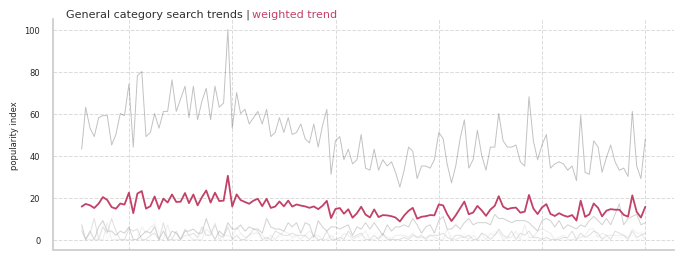

In [90]:
fig, ax = plt.subplots(figsize=(8, 3))  # Adjust the size as needed
plot_combined_trends(ax, trends_cat_general, trend_cat_general,'General',0.32)
plt.show()

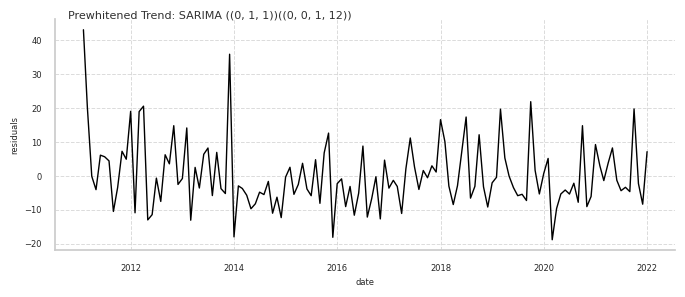

In [95]:
fig, ax = plt.subplots(figsize=(8, 3))  # Adjust the size as needed
plot_residuals(ax, residuals_general)
plt.show()

In [101]:
def full_plot(df_trends, df_consolidated, df_residuals, category_name, space, translated_terms):
    fig = plt.figure(figsize=(7, 7))  # Adjust the size as needed
    gs = GridSpec(3, 1, figure=fig, height_ratios=[1, 1, 0.2], hspace=0.2)

    # Plot 1: Combined trends on the first row
    ax1 = fig.add_subplot(gs[0, 0])
    plot_combined_trends(ax1, df_trends, df_consolidated, category_name, space)

    # Plot 2: Residuals on the second row
    ax2 = fig.add_subplot(gs[1, 0])
    plot_residuals(ax2, df_residuals)

    # Box with search terms aligned like a footnote under the plots
    ax3 = fig.add_subplot(gs[2, :])  # Spanning across all columns for the width
    ax3.axis('off')  # No plotting, just text

    # Concatenate translated search terms separated by a comma
    terms_str = ', '.join(translated_terms)

    # Use textwrap to break the text into multiple lines
    wrapper = textwrap.TextWrapper(width=150)  # Set the width to match the plot width
    wrapped_terms = wrapper.fill(text='Search terms by importance: ' + terms_str)

    # Place the wrapped text in the textbox
    ax3.text(0.01, 0, wrapped_terms, ha='left', va='bottom', fontsize=5, transform=ax3.transAxes)
    fig.savefig('/content/drive/MyDrive/Diversa/PUCE/Figures/'+category_name+'_trends.tiff', dpi=300, format='tiff', bbox_inches='tight')
    fig.savefig('/content/drive/MyDrive/Diversa/PUCE/Figures/'+category_name+'_trends.jpg', dpi=300, format='jpeg', bbox_inches='tight')
    plt.show()

In [106]:
term_importance = trends_cat_general.sum().sort_values(ascending=False)
term_importance.index.tolist()

['suicidio',
 'suicidarse',
 'suicidio en Ecuador',
 'suicidarme',
 'intento de suicidio']

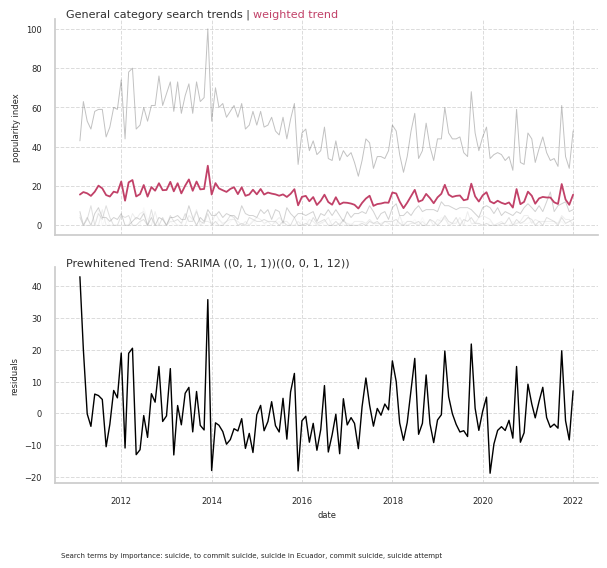

In [107]:
general_terms_EN = ['suicide', 'to commit suicide', 'suicide in Ecuador', 'commit suicide', 'suicide attempt']
full_plot(trends_cat_general, trend_cat_general, residuals_general, 'General', 0.365, general_terms_EN)

In [108]:
term_importance = trends_cat_seeking.sum().sort_values(ascending=False)
term_importance.index.tolist()

['sobredosis',
 'como suicidarse',
 'nota de suicidio',
 'como matarse',
 'como suicidarme',
 'matarme',
 'intento de suicidio',
 'como matarme',
 'matarse',
 'como suicidarse sin dolor',
 'formas de suicidio',
 'como suicidarme sin dolor',
 'formas de suicidarse',
 'suicidarse sin dolor',
 'suicidio asistido']

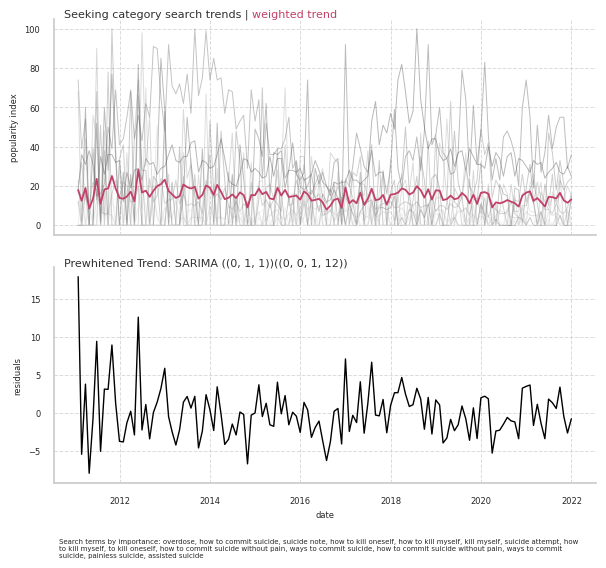

In [110]:
seeking_terms_EN = ['overdose',
 'how to commit suicide',
 'suicide note',
 'how to kill oneself',
 'how to kill myself',
 'kill myself',
 'suicide attempt',
 'how to kill myself',
 'to kill oneself',
 'how to commit suicide without pain',
 'ways to commit suicide',
 'how to commit suicide without pain',
 'ways to commit suicide',
 'painless suicide',
 'assisted suicide']
full_plot(trends_cat_seeking, trend_cat_seeking, residuals_seeking, 'Seeking', 0.365, seeking_terms_EN)

In [111]:
term_importance = trends_cat_prevention.sum().sort_values(ascending=False)
term_importance.index.tolist()

['psicologo',
 'psicoterapia',
 'psiquiatra',
 'psicólogo',
 'terapia psicologica + terapia psicológica',
 'sicologo',
 'atención psicológica + atencion psicologica',
 'siquiatra',
 'ayuda psicologica',
 'prevencion del suicidio',
 'ayuda psicológica']

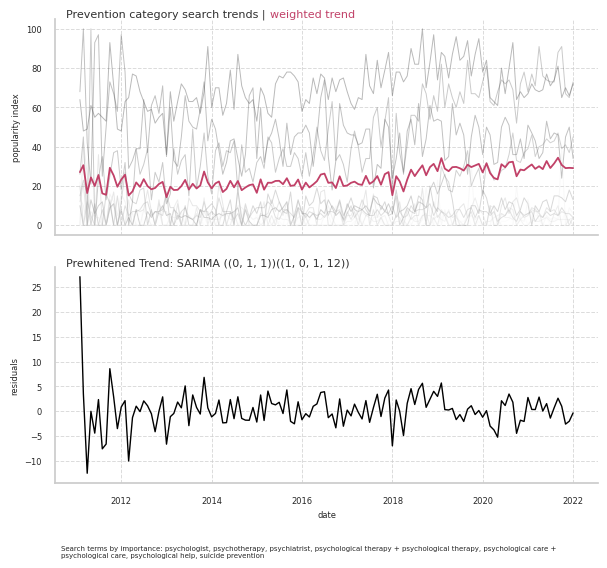

In [113]:
prevention_terms_EN = ['psychologist',
 'psychotherapy',
 'psychiatrist',
 'psychological therapy + psychological therapy',
 'psychological care + psychological care',
 'psychological help',
 'suicide prevention']
full_plot(trends_cat_prevention, trend_cat_prevention, residuals_prevention, 'Prevention', 0.395, prevention_terms_EN)

In [114]:
term_importance = trends_cat_mood.sum().sort_values(ascending=False)
term_importance.index.tolist()

['cansancio',
 'tengo miedo',
 'tristeza',
 'no tengo novio + no tengo novia',
 'estoy solo',
 'fatiga',
 'pánico + panico',
 'fobia',
 'cómo ser feliz + como ser feliz',
 'estoy triste',
 'mejorar el autoestima',
 'mejorar la autoestima',
 'me siento solo',
 'paz interior',
 'me siento sola',
 'no quiero vivir',
 'estoy cansado',
 'amarse a uno mismo',
 'estoy sola',
 'no tengo a nadie',
 'no tengo pareja',
 'estoy cansada',
 'no tengo amigos',
 'ataques de panico',
 'estoy enojado',
 'ya no quiero vivir',
 'sentimientos de tristeza',
 'ataque de pánico']

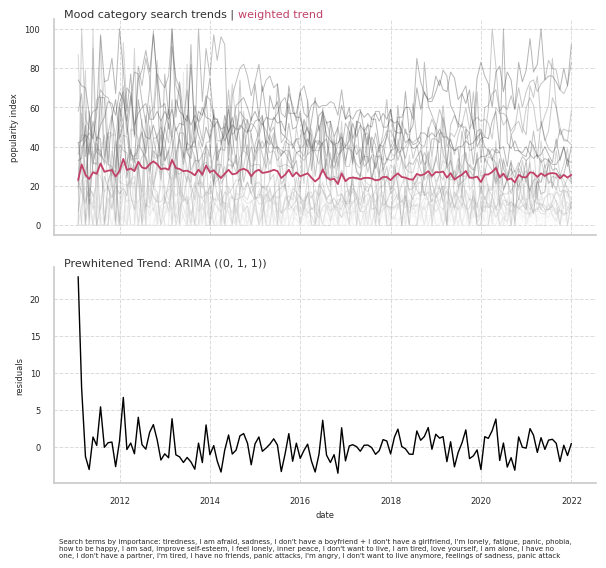

In [116]:
mood_terms_EN = ['tiredness',
 'I am afraid',
 'sadness',
 "I don't have a boyfriend + I don't have a girlfriend",
 "I'm lonely",
 'fatigue',
 'panic',
 'phobia',
 'how to be happy',
 'I am sad',
 'improve self-esteem',
 'I feel lonely',
 'inner peace',
 "I don't want to live",
 'I am tired',
 'love yourself',
 'I am alone',
 'I have no one',
 "I don't have a partner",
 "I'm tired",
 'I have no friends',
 'panic attacks',
 "I'm angry",
 "I don't want to live anymore",
 'feelings of sadness',
 'panic attack']
full_plot(trends_cat_mood, trend_cat_mood, residuals_mood, 'Mood', 0.34, mood_terms_EN)

In [117]:
term_importance = trends_cat_disorder.sum().sort_values(ascending=False)
term_importance.index.tolist()

['depresion',
 'esquizofrenia',
 'psicosis',
 'anorexia',
 'pastillas para dormir',
 'TOC',
 'ansiedad',
 'no puedo dormir',
 'depresion ecuador',
 'insomnio',
 'depresión',
 'bipolaridad',
 'antidepresivo',
 'trastorno bipolar',
 'alucinaciones',
 'depresión ecuador',
 'no tengo sueño',
 'trastorno del sueño',
 'estres postraumatico',
 'sicosis',
 'tengo pesadillas',
 'sintomas de depresion',
 'escuchar voces',
 'síntomas de esquizofrenia + sintomas de esquizofrenia',
 'TEPT',
 'tengo depresión + tengo depresion',
 'síntomas de la anorexia + sintomas de la anorexia',
 'tengo ansiedad',
 'tratamiento anorexia',
 'calmar la ansiedad',
 'síntomas de depresión',
 'síntomas de ansiedad',
 'estrés postraumatico']

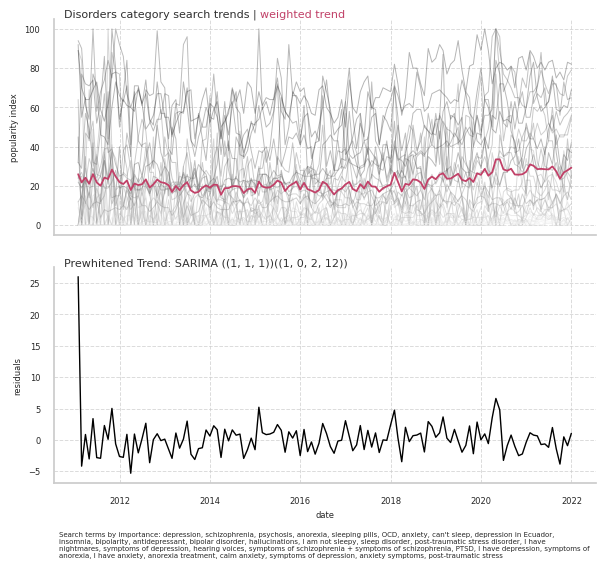

In [119]:
disorders_terms_EN = ['depression',
'schizophrenia',
'psychosis',
'anorexia',
'sleeping pills',
'OCD',
'anxiety',
"can't sleep",
'depression in Ecuador',
'insomnia',
'bipolarity',
'antidepressant',
'bipolar disorder',
'hallucinations',
'I am not sleepy',
'sleep disorder',
'post-traumatic stress disorder',
'I have nightmares',
'symptoms of depression',
'hearing voices',
'symptoms of schizophrenia + symptoms of schizophrenia',
'PTSD',
'I have depression',
'symptoms of anorexia',
'I have anxiety',
'anorexia treatment',
'calm anxiety',
'symptoms of depression',
'anxiety symptoms',
'post-traumatic stress']
full_plot(trends_cat_disorder, trend_cat_disorder, residuals_disorders, 'Disorders', 0.38, disorders_terms_EN)

In [120]:
term_importance = trends_cat_stress.sum().sort_values(ascending=False)
term_importance.index.tolist()

['divorcio',
 'burnout',
 'traicion',
 'infidelidad',
 'deudas',
 'separacion',
 'no tengo trabajo',
 'ruptura',
 'donde buscar trabajo',
 'separación',
 'estrés laboral',
 'me despidieron',
 'problemas economicos',
 'presión en el trabajo',
 'no tengo dinero',
 'ruptura amorosa',
 'problemas económicos',
 'me divorcie']

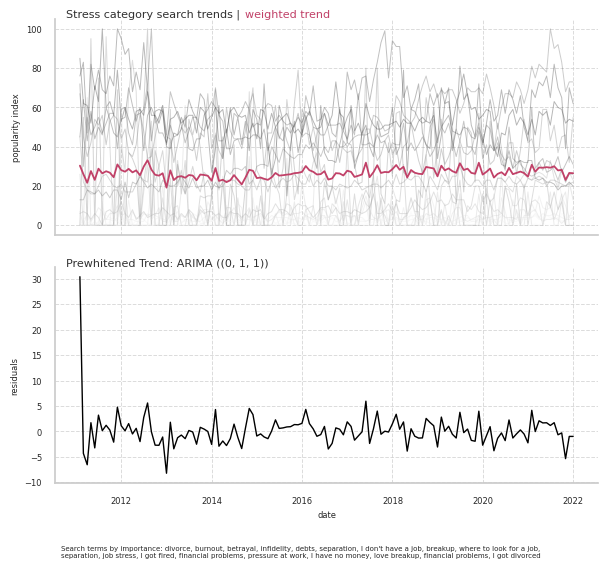

In [121]:
stess_terms_EN =['divorce',
 'burnout',
 'betrayal',
 'infidelity',
 'debts',
 'separation',
 "I don't have a job",
 'breakup',
 'where to look for a job',
 'separation',
 'job stress',
 'I got fired',
 'financial problems',
 'pressure at work',
 'I have no money',
 'love breakup',
 'financial problems',
 'I got divorced']
full_plot(trends_cat_stress, trend_cat_stress, residuals_stress, 'Stress', 0.35, stess_terms_EN)

In [122]:
term_importance = trends_cat_trauma.sum().sort_values(ascending=False)
term_importance.index.tolist()

['bullying',
 'abuso sexual',
 'amenazas',
 'violencia familiar',
 'violacion sexual',
 'maltrato familiar',
 'violencia doméstica + violencia domestica',
 'extorsión + extorsion']

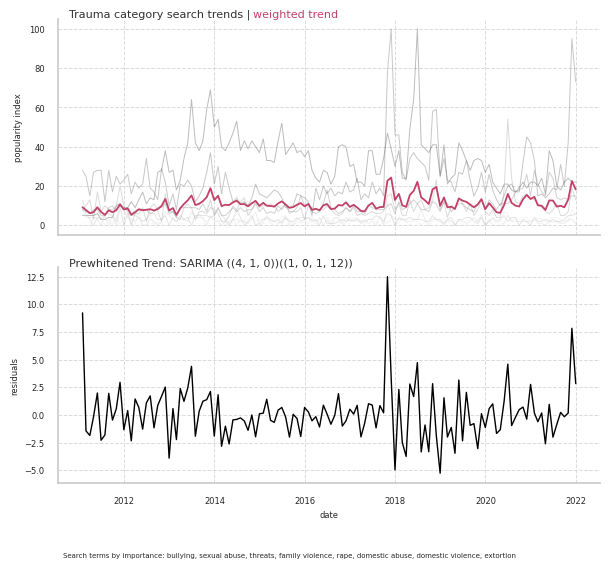

In [123]:
trauma_terms_EN =['bullying',
 'sexual abuse',
 'threats',
 'family violence',
 'rape',
 'domestic abuse',
 'domestic violence',
 'extortion']
full_plot(trends_cat_trauma, trend_cat_trauma, residuals_trauma, 'Trauma', 0.36, trauma_terms_EN)

In [124]:
term_importance = trends_cat_minorities.sum().sort_values(ascending=False)
term_importance.index.tolist()

['homofobia',
 'trabajo eeuu + trabajo estados unidos',
 'racismo',
 'xenofobia',
 'trabajo mexico + trabajo México',
 'transfobia',
 'lesbofobia',
 'como migrar',
 'discriminación racial']

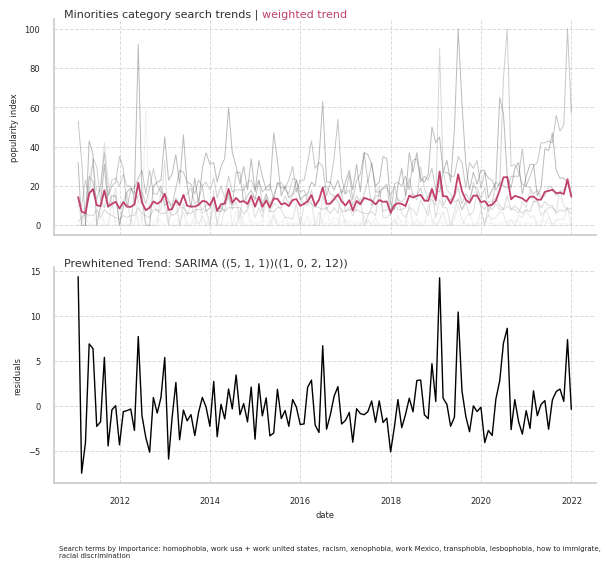

In [127]:
minorities_terms_EN = ['homophobia',
 'work usa + work united states',
 'racism',
 'xenophobia',
 'work Mexico',
 'transphobia',
 'lesbophobia',
 'how to immigrate',
 'racial discrimination']
full_plot(trends_cat_minorities, trend_cat_minorities, residuals_minorities, 'Minorities', 0.385, minorities_terms_EN)

In [128]:
term_importance = trends_cat_digital.sum().sort_values(ascending=False)
term_importance.index.tolist()

['cyberbullying',
 'ciberacoso',
 'bullying cibernético',
 'acoso en redes sociales',
 'acoso en internet']

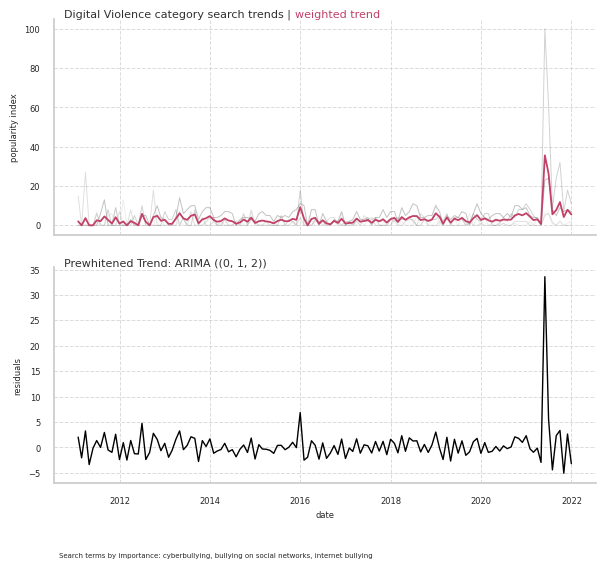

In [129]:
digital_terms_EN = ['cyberbullying', 'bullying on social networks', 'internet bullying']
full_plot(trends_cat_digital, trend_cat_digital, residuals_digital, 'Digital Violence', 0.445, digital_terms_EN)